Due to the random selection of rows, some variation is introduced in the selection of the training, test, and validation sets each time this notebook is run. This is the source of any deviation between the results recorded here and those reported in the attached paper.

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy.linalg as la
import scipy.io as sio
from math import floor

# Load the data

In [2]:
file = 'hwkdataNEW.mat'
data_dict = sio.loadmat(file)
print(data_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'x', 'y'])


Extract the parts we want and examine them

In [3]:
x = data_dict['x']
y = data_dict['y']

In [4]:
x.shape

(247, 14)

In [5]:
y.shape

(247, 1)

We want to put this all into the `pandas` data format

In [6]:
column_names = ['Age', 'Weight', 'Height', 'Adiposity Index', 
                'Neck Circumference', 'Chest Circumference', 
                'Abdomen Circumference', 'Hip Circumference',
                'Thigh Circumference', 'Knee Circumference',
                'Ankle Circumference', 'Extended Bicep Circumference',
                'Forearm Circumference', 'Wrist Circumference',
                'Body Fat Percentage']

In [7]:
data = pd.DataFrame(x, columns=column_names[:-1]) # Last column contains y

In [8]:
data[column_names[-1]] = y

In [9]:
data.head()

,Age,Weight,Height,Adiposity Index,Neck Circumference,Chest Circumference,Abdomen Circumference,Hip Circumference,Thigh Circumference,Knee Circumference,Ankle Circumference,Extended Bicep Circumference,Forearm Circumference,Wrist Circumference,Body Fat Percentage
0,23.0,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6
1,22.0,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9
2,22.0,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6
3,26.0,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9
4,24.0,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8


Data is now a pandas DataFrame that contains the information we need

# Sort into Train, Test, and Validation

Since the rows of data should be indpendent and uncorrelated, I have chosen to simply shuffle them then tag them as belonging to one of the named data sets (`train`, `test`, or `validation`).

In [10]:
train_frac = 0.6
test_frac = 0.2
val_frac = 0.2

train_len = floor(len(data) * train_frac)
test_len = floor(len(data) * test_frac)
val_len = floor(len(data) * val_frac)
rows_used = train_len + test_len + val_len
# Make sure all rows being used by adding unused
# rows into the training set
while rows_used < len(data):
    train_len += 1
    rows_used = train_len + test_len + val_len
print(f'Rows in original dataset: {len(data)}')
print(f'Rows in training dataset: {train_len}')
print(f'Rows in testing dataset: {test_len}')
print(f'Rows in validation dataset: {val_len}')
print(f'Rows used: {train_len + test_len + val_len}')

Rows in original dataset: 247
Rows in training dataset: 149
Rows in testing dataset: 49
Rows in validation dataset: 49
Rows used: 247


In [11]:
# Shuffle and reindex the dataset
data = data.sample(frac=1).reset_index(drop=True)
# Split the data into three datasets
dataset_labels = np.zeros(len(data)).astype('str')
dataset_labels[:train_len] = 'train'
dataset_labels[train_len:train_len + test_len] = 'test'
dataset_labels[-val_len:] = 'val'
data['sample'] = dataset_labels

## TO DO: Make sure max and min for each column is in training set

# Regression

Explanation of regression

In [12]:
train = data[data['sample']=='train']

In [13]:
def regress(x, y):
    """Returns coefficient of regression"""
    # One-pad x
    o = np.ones_like(x[:,0]).reshape((-1, 1))
    
    x = np.hstack([x, o])
    
    # Perform regression
    coefficients = la.inv(x.T @ x) @ x.T @ y
    
    return coefficients

In [14]:
def performance(x_test, y_test, coefficients):
    """Root mean squared error"""
    # One-pad x
    o = np.ones_like(x_test[:,0]).reshape((-1, 1))
    x_test = np.hstack([x_test, o])
    
    # Make predictions
    y_pred = x_test @ coefficients

    # Calculate RMSE
    return np.sqrt(np.sum((y_test - y_pred) ** 2) / y_test.shape[0])

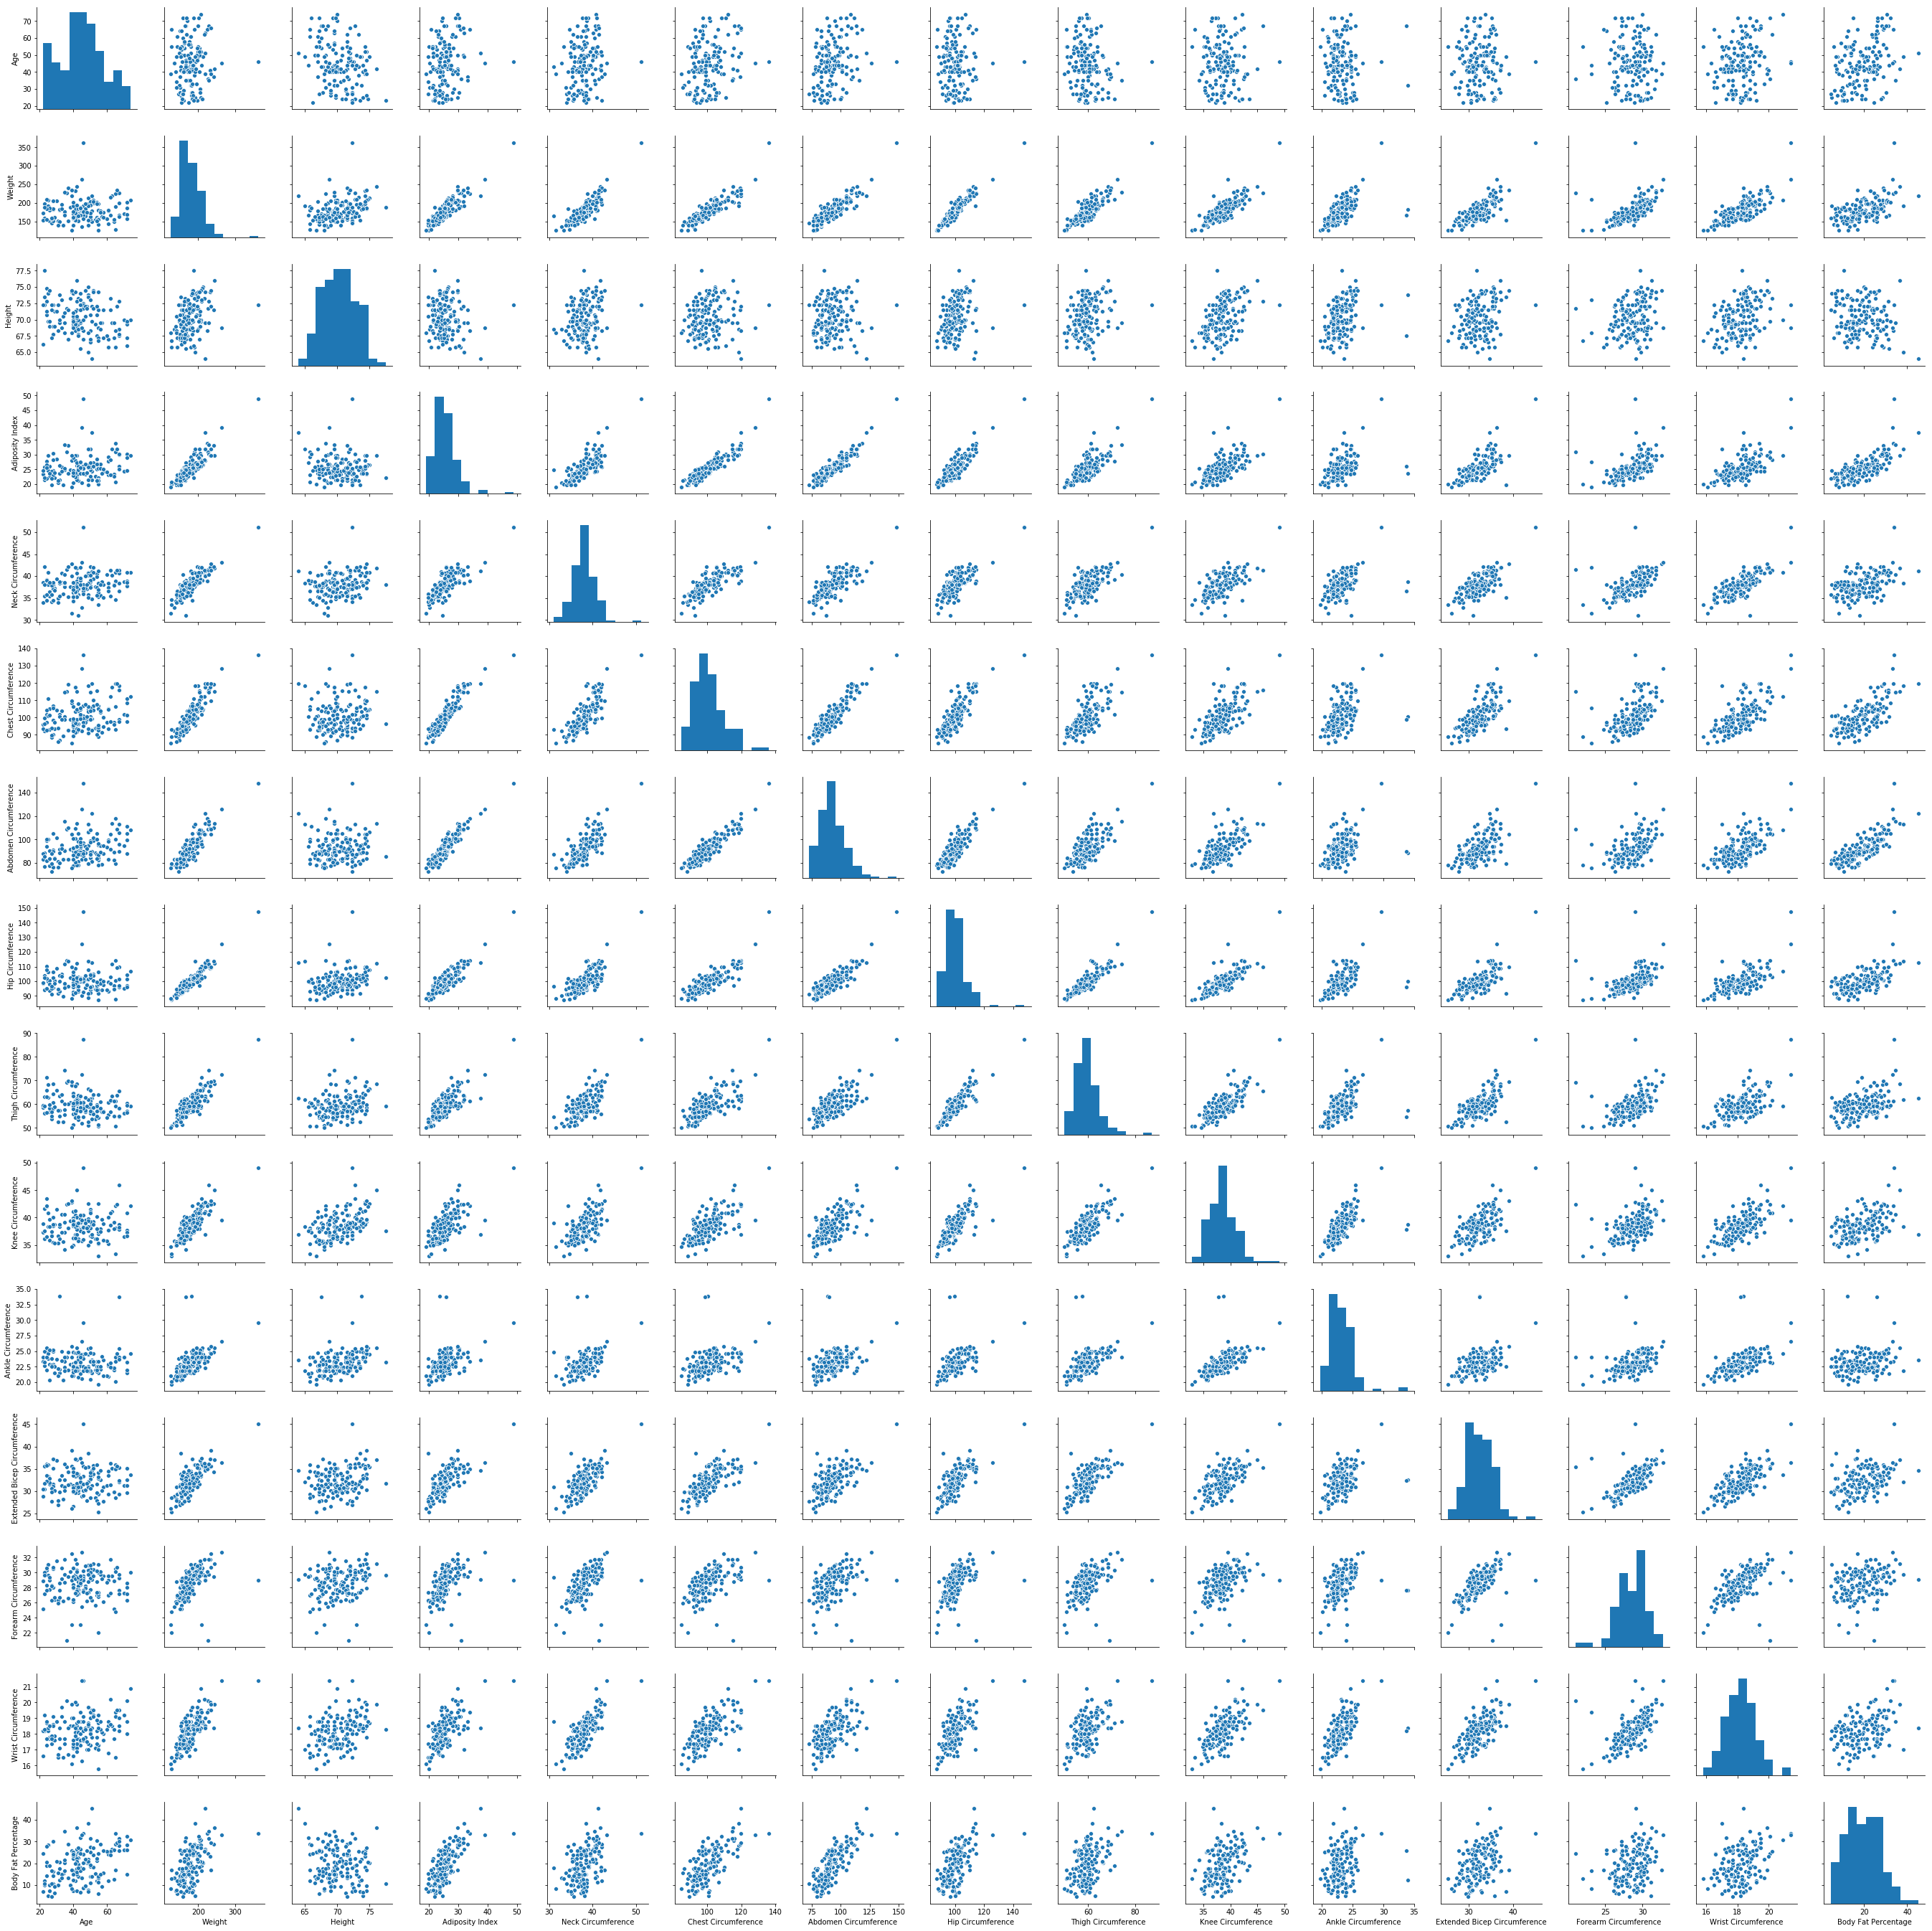

In [15]:
sns.pairplot(train)

Wow, that's a little unweildy. Let's try just the correlation matrix

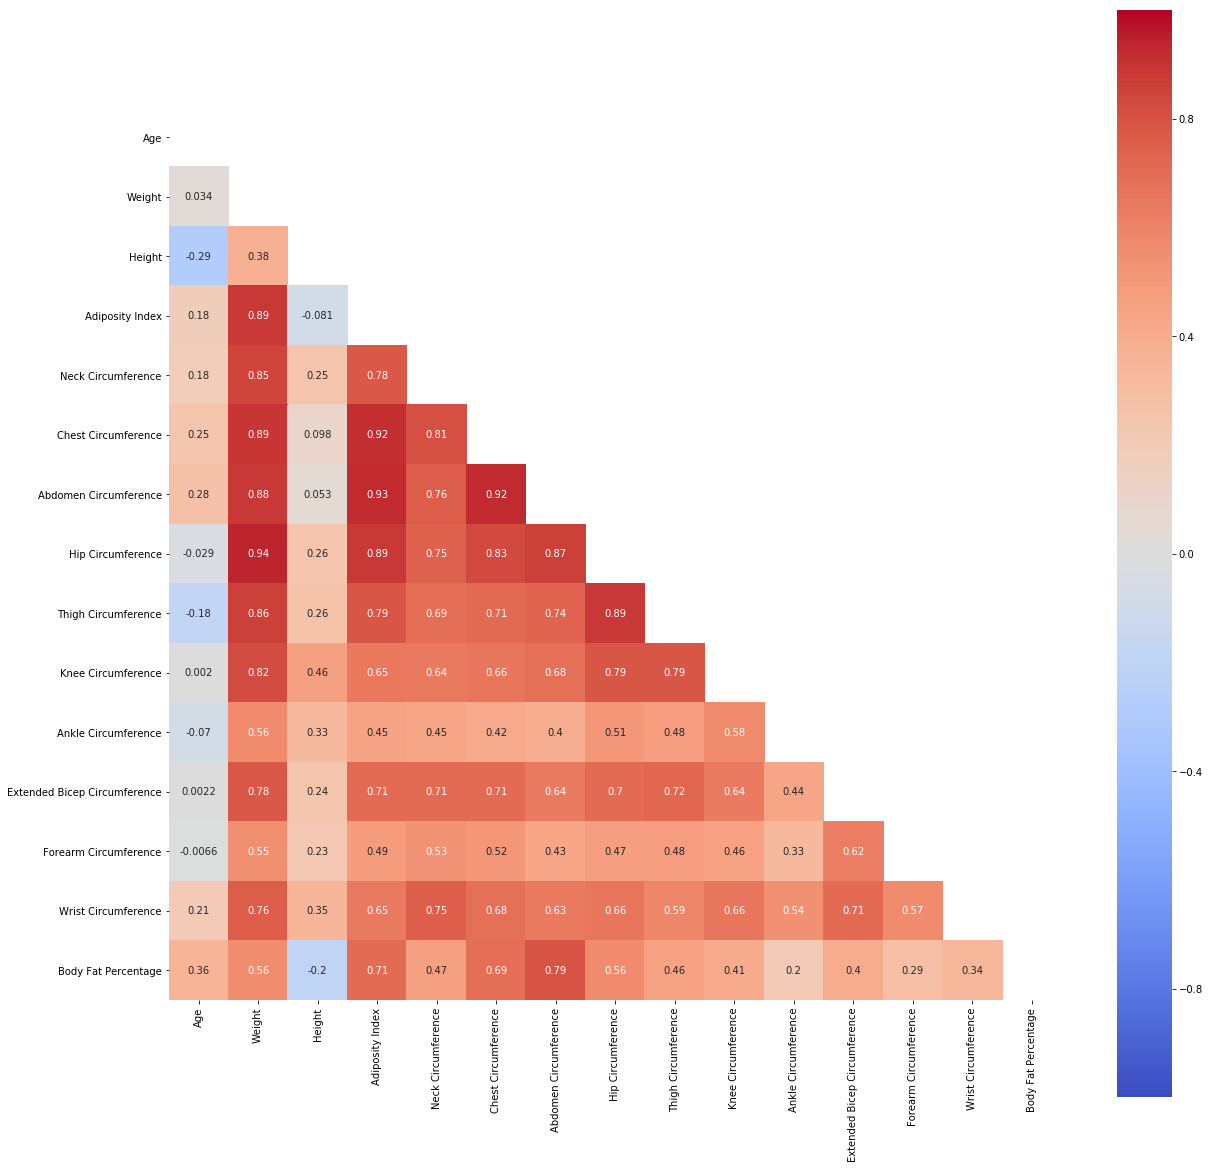

In [16]:
plt.figure(figsize=(20,20))
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap='coolwarm', annot=True, mask=mask)
plt.show()

## Attempt a 1-value regression for each column

In [17]:
test = data[data['sample'] == 'test']
test_performance = {'one_factor': {}}
for name in column_names[:-1]:
    test_performance['one_factor'][name] = performance(
        test[name].values.reshape(-1, 1),
        test['Body Fat Percentage'].values,
        regress(train[name].values.reshape(-1, 1), train['Body Fat Percentage'].values)
    )
print('Root mean squared error vs regressor')
print('------------------------------------')
for f, p in test_performance['one_factor'].items():
    print(f'{f}\t\t{p:0.2f}')

Root mean squared error vs regressor
------------------------------------
Age		7.57
Weight		5.16
Height		8.15
Adiposity Index		4.71
Neck Circumference		6.00
Chest Circumference		4.93
Abdomen Circumference		3.67
Hip Circumference		5.34
Thigh Circumference		5.50
Knee Circumference		5.51
Ankle Circumference		7.06
Extended Bicep Circumference		5.99
Forearm Circumference		6.48
Wrist Circumference		6.75


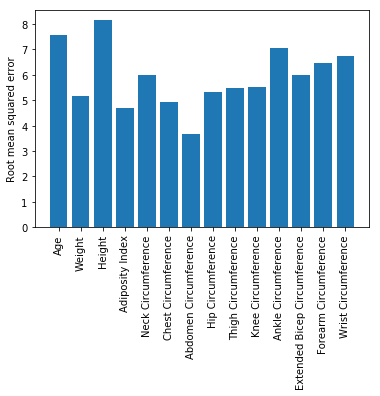

In [18]:
f = plt.figure()
plt.bar(x=column_names[:-1], height=[v for v in test_performance['one_factor'].values()])
plt.xticks(rotation=90)
plt.ylabel('Root mean squared error')
plt.show()

# Pairwise Regression

In [19]:
from itertools import combinations

In [20]:
combs = combinations(column_names[:-1], 2)

In [21]:
two_factor = {}
for _ in combs:
    c = [i for i in _]
    p = performance(test[c].values, test['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))
    two_factor[tuple(c)] = p
    print(f'{c} \t\t\t\t {p:0.2f}')

['Age', 'Weight'] 				 5.02
['Age', 'Height'] 				 7.90
['Age', 'Adiposity Index'] 				 4.71
['Age', 'Neck Circumference'] 				 6.00
['Age', 'Chest Circumference'] 				 4.89
['Age', 'Abdomen Circumference'] 				 3.77
['Age', 'Hip Circumference'] 				 5.14
['Age', 'Thigh Circumference'] 				 5.18
['Age', 'Knee Circumference'] 				 5.80
['Age', 'Ankle Circumference'] 				 7.03
['Age', 'Extended Bicep Circumference'] 				 5.90
['Age', 'Forearm Circumference'] 				 6.40
['Age', 'Wrist Circumference'] 				 7.02
['Weight', 'Height'] 				 5.19
['Weight', 'Adiposity Index'] 				 5.03
['Weight', 'Neck Circumference'] 				 5.15
['Weight', 'Chest Circumference'] 				 5.22
['Weight', 'Abdomen Circumference'] 				 3.72
['Weight', 'Hip Circumference'] 				 5.18
['Weight', 'Thigh Circumference'] 				 5.21
['Weight', 'Knee Circumference'] 				 5.30
['Weight', 'Ankle Circumference'] 				 5.04
['Weight', 'Extended Bicep Circumference'] 				 5.18
['Weight', 'Forearm Circumference'] 				 5.19
['Weight', '

In [22]:
print(max(two_factor, key=two_factor.get))
print(max([v for v in two_factor.values()]))

('Age', 'Height')
7.901445978984846


In [23]:
print(min(two_factor, key=two_factor.get))
print(min([v for v in two_factor.values()]))

('Abdomen Circumference', 'Wrist Circumference')
3.5561491191764545


# All 14 Variables

In [24]:
p = performance(x_test=test[column_names[:-1]].values,
                y_test=test['Body Fat Percentage'].values,
                coefficients=regress(
                    train[column_names[:-1]].values,
                    train['Body Fat Percentage'].values,
                ))
test_performance['All inputs performance'] = p
print(f'All inputs performance\t\t{p:0.2f}')

All inputs performance		3.41


# My best guess

In [25]:
predictive_columns = ['Abdomen Circumference', 'Wrist Circumference', 'Height']
p = performance(x_test=test[predictive_columns].values,
                y_test=test['Body Fat Percentage'].values,
                coefficients=regress(
                    train[predictive_columns].values,
                    train['Body Fat Percentage'].values,
                ))
test_performance['Predictive columns performance'] = p
print(f'Predictive columns performance\t\t{p:0.2f}')

Predictive columns performance		3.70


# Non-linear terms

In order to improve the model it's worth trying higher-order (non-linear) terms.

Add a term for the square of each input variable

In [26]:
for c in column_names[:-1]:
    data[f'{c}^2'] = data[c] * data[c]

Add a term for the product of each combination of two variables

In [27]:
combs = combinations(column_names[:-1], 2)
for c1, c2 in combs:
    data[f'{c1} x {c2}'] = data[c1] * data[c2]

In [28]:
for c in column_names[:-1]:
    data[f'{c}^-1'] = data[c] ** -1

In [29]:
train = data[data['sample']=='train']
test = data[data['sample'] == 'test']

In [30]:
train.head()

,Age,Weight,Height,Adiposity Index,Neck Circumference,Chest Circumference,Abdomen Circumference,Hip Circumference,Thigh Circumference,Knee Circumference,...,Neck Circumference^-1,Chest Circumference^-1,Abdomen Circumference^-1,Hip Circumference^-1,Thigh Circumference^-1,Knee Circumference^-1,Ankle Circumference^-1,Extended Bicep Circumference^-1,Forearm Circumference^-1,Wrist Circumference^-1
0,43.0,164.25,73.25,21.3,35.7,96.6,81.5,97.2,58.4,38.2,...,0.028011,0.010352,0.012270,0.010288,0.017123,0.026178,0.042735,0.033670,0.036496,0.054645
1,36.0,226.75,71.75,31.0,41.5,115.3,108.8,114.4,69.2,42.4,...,0.024096,0.008673,0.009191,0.008741,0.014451,0.023585,0.041667,0.028249,0.047619,0.049751
2,45.0,135.75,68.50,20.4,32.8,92.3,83.4,90.4,52.0,35.8,...,0.030488,0.010834,0.011990,0.011062,0.019231,0.027933,0.048544,0.034722,0.039216,0.061350
3,48.0,173.75,72.00,23.6,37.0,99.1,92.0,98.3,59.3,38.4,...,0.027027,0.010091,0.010870,0.010173,0.016863,0.026042,0.044643,0.035842,0.038168,0.058824
4,24.0,208.50,72.75,27.7,39.2,102.0,99.1,110.1,71.2,43.5,...,0.025510,0.009804,0.010091,0.009083,0.014045,0.022989,0.039683,0.027701,0.033003,0.053476


In [31]:
train.columns

Index(['Age', 'Weight', 'Height', 'Adiposity Index', 'Neck Circumference',
       'Chest Circumference', 'Abdomen Circumference', 'Hip Circumference',
       'Thigh Circumference', 'Knee Circumference',
       ...
       'Neck Circumference^-1', 'Chest Circumference^-1',
       'Abdomen Circumference^-1', 'Hip Circumference^-1',
       'Thigh Circumference^-1', 'Knee Circumference^-1',
       'Ankle Circumference^-1', 'Extended Bicep Circumference^-1',
       'Forearm Circumference^-1', 'Wrist Circumference^-1'],
      dtype='object', length=135)

In [32]:
train_x = train.drop(['Body Fat Percentage', 'sample'], axis=1)
print(*train_x.columns, sep='\n')

Age
Weight
Height
Adiposity Index
Neck Circumference
Chest Circumference
Abdomen Circumference
Hip Circumference
Thigh Circumference
Knee Circumference
Ankle Circumference
Extended Bicep Circumference
Forearm Circumference
Wrist Circumference
Age^2
Weight^2
Height^2
Adiposity Index^2
Neck Circumference^2
Chest Circumference^2
Abdomen Circumference^2
Hip Circumference^2
Thigh Circumference^2
Knee Circumference^2
Ankle Circumference^2
Extended Bicep Circumference^2
Forearm Circumference^2
Wrist Circumference^2
Age x Weight
Age x Height
Age x Adiposity Index
Age x Neck Circumference
Age x Chest Circumference
Age x Abdomen Circumference
Age x Hip Circumference
Age x Thigh Circumference
Age x Knee Circumference
Age x Ankle Circumference
Age x Extended Bicep Circumference
Age x Forearm Circumference
Age x Wrist Circumference
Weight x Height
Weight x Adiposity Index
Weight x Neck Circumference
Weight x Chest Circumference
Weight x Abdomen Circumference
Weight x Hip Circumference
Weight x Thig

In [33]:
theory_1_columns = ['Abdomen Circumference', 'Weight^-1', 'Height', 'Wrist Circumference']
c = theory_1_columns
performance(test[c].values, test['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

3.683762778355379

In [34]:
theory_2_columns = ['Abdomen Circumference', 'Weight^-1', 'Height', 'Wrist Circumference']
c = theory_2_columns
performance(test[c].values, test['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

3.683762778355379

In [35]:
theory_3_columns = train_x.columns
c = theory_3_columns
performance(test[c].values, test['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

20.737652502714663

# Final Validation Performance Calculations

The final performance for the "best" models from the categories above will now be calculated on the validation set

In [36]:
val = data[data['sample'] == 'val']

## Single variable performance

In [37]:
one_variable_columns = ['Abdomen Circumference']
c = one_variable_columns
performance(val[c].values, val['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

4.265121424789481

## Two variable performance

In [38]:
two_variable_columns = ['Abdomen Circumference', 'Wrist Circumference']
c = two_variable_columns
performance(val[c].values, val['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

3.9050699059210032

In [39]:
other_two_variable_columns = ['Abdomen Circumference', 'Height']
c = other_two_variable_columns
performance(val[c].values, val['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

4.52611272089604

In [40]:
another_two_variable_columns = ['Abdomen Circumference', 'Age']
c = another_two_variable_columns
performance(val[c].values, val['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

4.300874979416831

## 14 variable performance

In [41]:
fourteen_variable_columns = column_names[:-1]
c = fourteen_variable_columns
performance(val[c].values, val['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

4.265218559119979

Just goes to show the value of a validation set...

## "Best guess" variables

In [42]:
best_guess_columns = ['Abdomen Circumference', 'Wrist Circumference', 'Height']
c = best_guess_columns
performance(val[c].values, val['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

4.223629635987778

## Linear in parameters

In [43]:
linear_in_parameters_columns = ['Abdomen Circumference', 'Weight^-1', 'Height', 'Wrist Circumference']
c = linear_in_parameters_columns
performance(val[c].values, val['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

4.189345933006309

# Statistical Perspective

In [44]:
s = train['Body Fat Percentage'].std()

In [45]:
s

7.902927289914957

In [46]:
s/2

3.9514636449574785

In [47]:
6.84 / s

0.8655020790496991

In [48]:
3.87 / s

0.4896919657781193

In [49]:
from scipy.stats import norm

In [50]:
norm.cdf(0.5) - norm.cdf(-0.5)

0.38292492254802624

In [51]:
norm.cdf(1.0) - norm.cdf(-1.0)

0.6826894921370859

In [52]:
norm.cdf(6.84 / s) - norm.cdf(-6.84 / s)

0.6132367246886898

# Reproducing Penrose

In [54]:
penrose_columns = [
    'Weight', 'Age', 'Age^2',
    'Height', 'Abdomen Circumference',
    'Wrist Circumference'
]
c = penrose_columns
performance(val[c].values, val['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))

4.3673819767976205